In [4]:
# Create function to load dataset from csv file. Data from month column will be output as X_month,
# data from day column will be output as X_day, data from hour column will be output as X_hour,
# data from tx_count will be output as y, and all other data will be output as X_numeric.
# All data will be converted to tensors.

import os
import pandas as pd
import torch

def load_dataset(
    csv_file: os.PathLike,
    window_size: int
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    # Read the raw data from the file
    df = pd.read_csv(csv_file)

    # Conver the data to tensors
    raw_X_month = torch.tensor(df['month'].values)
    raw_X_day = torch.tensor(df['day'].values)
    raw_X_hour = torch.tensor(df['hour'].values)
    raw_X_numeric = torch.tensor(df.drop(['month', 'day', 'hour', 'y'], axis=1).values).float()
    raw_y = torch.tensor(df['y'].values).float()

    # Make sure we are using a window size that makes sense with our data
    window_size = min(window_size, len(raw_X_month) // 2)

    # Get sliding windows of the data
    X_month = raw_X_month.unfold(0, 2 * window_size, 1)
    X_day = raw_X_day.unfold(0, 2 * window_size, 1)
    X_hour = raw_X_hour.unfold(0, 2 * window_size, 1)
    X_numeric = raw_X_numeric.unfold(0, 2 * window_size, 1).transpose(-1, -2)
    y = raw_y.unfold(0, 2 * window_size, 1)
    y = y[:, -window_size:]

    return X_month, X_day, X_hour, X_numeric, y

In [5]:
# Create a PyTorch model that takes in 4 inputs (X_month, X_day, X_hour, X_numeric)
# and outputs a series of predictions (y). It will feed X_month, X_day, and X_hour into embedding layers,
# which will then be concatenated with X_numeric and fed into an LSTM layer.

import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embedding_month = nn.Embedding(12, 2)
        self.embedding_day = nn.Embedding(31, 25)
        self.embedding_hour = nn.Embedding(24, 50)
        self.lstm = nn.LSTM(82, 80, 10, bidirectional=True, batch_first=True, dropout=0.1)
        self.linear = nn.Sequential(
            nn.Linear(160, 40),
            nn.Linear(40, 10),
            nn.Linear(10, 1)
        )

    def forward(self, X_month, X_day, X_hour, X_numeric):
        X_month = self.embedding_month(X_month)
        X_day = self.embedding_day(X_day)
        X_hour = self.embedding_hour(X_hour)
        X = torch.cat((X_month, X_day, X_hour, X_numeric), dim=-1)
        X, _ = self.lstm(X)
        X = self.linear(X)
        return X.squeeze()[:, -24:]

In [6]:
# Create a function to train an instance of Model on a given dataset.

import torch.optim as optim
from tqdm.notebook import tqdm

def train_model(
    model: Model,
    X_month: torch.Tensor,
    X_day: torch.Tensor,
    X_hour: torch.Tensor,
    X_numeric: torch.Tensor,
    y: torch.Tensor,
    epochs: int
) -> list[float]:
    criterion = nn.MSELoss()
    optimizer = optim.Adagrad(model.parameters(), lr=0.01)

    pbar = tqdm(range(epochs))
    losses = []
    for i in pbar:
        model.train()
        optimizer.zero_grad()

        y_pred = model(X_month, X_day, X_hour, X_numeric)
        loss = criterion(y_pred, y)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        pbar.set_description(f'Loss: {loss.item()}')
    return losses

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# TODO: Fix this
def cross_validate(X_month, X_day, X_hour, X_numeric, y, epochs, cv=5) -> list[list[float]]:
    tscv = TimeSeriesSplit(n_splits=cv)
    pbar = tqdm(tscv.split(X_numeric))
    split_losses = []
    for train_index, test_index in pbar:
        X_month_train, X_day_train, X_hour_train, X_numeric_train, y_train = X_month[train_index], X_day[train_index], X_hour[train_index], X_numeric[train_index], y[train_index]
        X_month_test, X_day_test, X_hour_test, X_numeric_test, y_test = X_month[test_index], X_day[test_index], X_hour[test_index], X_numeric[test_index], y[test_index]

        model = Model()
        losses = train_model(model, X_month_train, X_day_train, X_hour_train, X_numeric_train, y_train, epochs)
        y_pred = model(X_month_test, X_day_test, X_hour_test, X_numeric_test)
        loss = nn.L1Loss()(y_pred, y_test)
        pbar.set_description(f"Fold MAE: {loss.item()}")
        split_losses.append(losses)

    return split_losses


In [ ]:
# Load training dataset and perform cross-validation
X_month, X_day, X_hour, X_numeric, y = load_dataset('data/train.csv', 24)
split_losses = cross_validate(X_month, X_day, X_hour, X_numeric, y, 1000, cv=5)

In [3]:
import math

avg_losses = [
    sum([losses[i] for losses in split_losses]) / len(split_losses)
    for i in range(len(split_losses[0]))
]
plot = [math.log(l) for l in avg_losses]
plt.plot(plot)

NameError: name 'split_losses' is not defined

In [14]:
with torch.device("cuda"):
    X_month, X_day, X_hour, X_numeric, y = load_dataset('data/train.csv', 24)
    X_month_test, X_day_test, X_hour_test, X_numeric_test, y_test = load_dataset(
        'data/test.csv',
        24
    )

    model = Model()
    losses = train_model(model, X_month, X_day, X_hour, X_numeric, y, 3_000)
    with torch.no_grad():
        y_preds = model(X_month_test, X_day_test, X_hour_test, X_numeric_test)

  0%|          | 0/3000 [00:00<?, ?it/s]

IndexError: too many indices for tensor of dimension 1

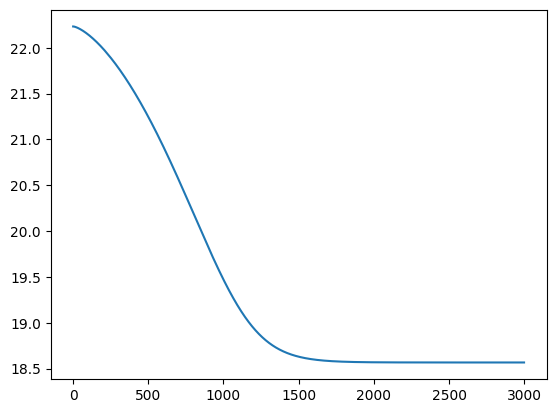

In [11]:
import math
import matplotlib.pyplot as plt

# Plot losses
plot = [math.log(l) for l in losses]
plt.plot(plot)

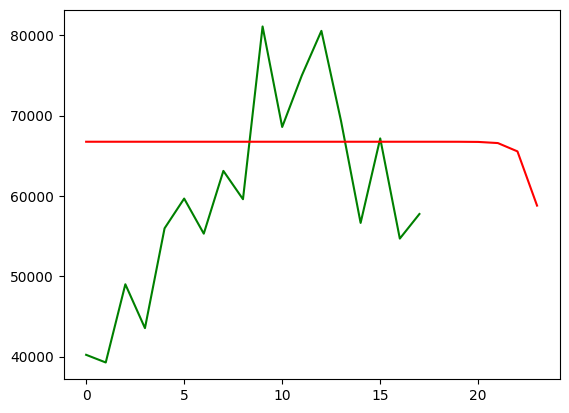

In [13]:
# Use matplotlib to plot y_test in green and y_preds in red
plt.plot(y_test[0].cpu(), color='green')
plt.plot(y_preds[0].cpu(), color='red')
plt.show()